In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket as socket
import os as os
import sys as sys
import multiprocessing as mp
import h5py
import allel

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

compute-a-16-154.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 32


In [6]:
f = h5py.File("./data/hdf5/1240k_v43/ch3.h5", "r") # Load for Sanity Check. See below!

In [138]:
f.close()

In [3]:
list(f["calldata"])

['AD', 'DS', 'GP', 'GT', 'HS', 'PL']

In [7]:
list(f["variants"])

['AF',
 'ALT',
 'BUF',
 'CHROM',
 'FILTER_PASS',
 'ID',
 'INFO',
 'MAP',
 'POS',
 'QUAL',
 'RAF',
 'REF',
 'altlen',
 'is_snp',
 'numalt']

### Plot call qualities

In [4]:
def get_idx_iid(f,sample, unique=True):
    """Return Index of sample samples in hdf5 f"""
    samples = pd.Series(f["samples"][:])
    idx = samples.str.contains(sample)
    idx = np.where(idx)[0]
    if unique:
        assert(len(idx)==1)
        return idx[0]
    else:
        return idx
    
def plot_max_p_gt(f, sample, cutoff=0.98,
                  bins=np.linspace(0.4,1.0,61)):
    """Plot the maximum probablity genotype for sample sample in
    hdf5 f.
    cutoff: Fraction SNPs above cutoff"""
    j = get_idx_iid(f, sample=sample)
    m = np.max(f["calldata/GP"][:,j,:], axis=1)
    c = np.mean(m>cutoff)
    
    ### Plot
    plt.figure()
    ax = plt.gca()
    ax.hist(m, bins=bins,ec="k")
    ax.set_ylim(0,1000)
    ax.text(x=0.05,y=0.9, s=f"Frac. Loci Max. Prob.>{cutoff}: {c:.4f}",  transform = ax.transAxes, fontsize=12)
    plt.show()

### Sardinian MA89 with 3x

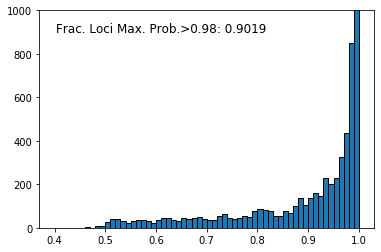

In [81]:
plot_max_p_gt(f, sample="MA89")

### Inbred Italian with 0.6x

### Consangineous Netherlands Bell Beaker ~0.8x 1240K

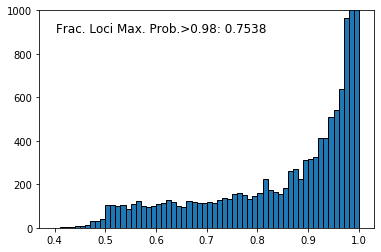

In [83]:
plot_max_p_gt(f, sample="I4068")

### Consangineous Italian with 0.6x

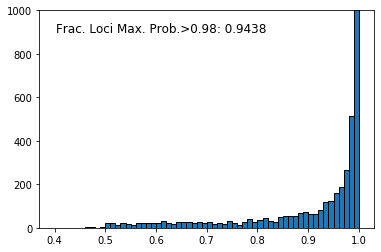

In [82]:
plot_max_p_gt(f, sample="R121.SG")

# Plot hets along genome

In [155]:
def get_coverage(f, j):
    """Get Coverage of sample j in hdf5 f"""
    ads =  f["calldata/AD"][:,j,:]
    ads[ads<0]=0
    cov = np.mean(ads)*2
    return cov

def plot_hets(map_het, het, df_roh=[], het_c="slateblue", c_roh="seagreen", 
              figsize=(14,2), cm_lim=[], fs = 12,
              alpha=0.3, ms=1, lw = 12, title="", plot=True, min_cm=0, savepath=""):
    """Plot Heterozygotes against genenetic map,
    plus ROH calls.
    lw: Linewidth of ROH""" 
    plt.figure(figsize=figsize)
    ax1 = plt.gca()
    ax1.plot(map_het*100, (het * 1.1 - 0.05), "o", ms=ms, alpha=alpha, zorder=0, color=het_c)
    ax1.set_xlabel("centimorgan", fontsize=fs)
    ax1.set_ylim([-0.1, 1.1])
    
    ax2 = ax1.twinx()
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_yticks(np.array([1,0]) * 1.1 - 0.05)
    ax2.set_yticklabels([])
    ax1.set_yticklabels([])

    ylabel = f"Heterozygote (yes/no)"
    ax2.set_ylabel(ylabel, fontsize=fs*0.8, color=het_c, rotation=270, labelpad=fs)
    
    ### Plot Calls
    if len(df_roh)>0:
        df_roh = df_roh[df_roh["lengthM"]>min_cm/100.0]  # Filter out long enough calls
        plt.hlines(y=[0.9]*len(df_roh), xmin=100 * df_roh["StartM"], xmax= 100 * df_roh["EndM"], 
                        colors=c_roh, linewidth=lw)
        
    if len(cm_lim)==2:
        ax1.set_xlim(cm_lim)
        
    if len(title)>0:
        ax1.set_title(title, fontsize=fs)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
        print(f"Saved figure to: {savepath}")
        #plt.savefig(folder + "posterior_cm.png", bbox_inches = 'tight', pad_inches = 0, dpi=300)
    
    if plot:
        plt.show()  


def plot_hets_roh(f, df_roh=[], ch=17, sample="SZPKAP0003",
                  add_txt = ", 1240K SNPs", cm_lim=[],
                  het_c="blue", figsize=(14,2), fs = 13,
                  alpha=0.3, ms=1, title="", plot=True, savepath=""):
    """Plot heterozygote markers, as well as inferred ROH.
    f: HDF5 genotype data to plot
    df_roh: ROH to plot. If len==0, do not plot anything"""
    idx_f = f["variants/CHROM"][:]==str(ch)
    idx_s = f["samples"][:].astype("str")==sample
    assert(np.sum(idx_s)==1)
    
    ### Extract Marker and Genotypes
    gt = f["calldata/GT"][:,idx_s,:][idx_f,0,:]
    m = f["variants/MAP"][idx_f]
    het = gt[:,0]!=gt[:,1]
    
    ### Extract ROH 
    df=df_roh[df_roh["iid"]==sample]
    df=df[df["ch"]==ch]
    
    title = f"{sample}, Chromosome {ch}{add_txt}"
    plot_hets(m, het, df_roh=df, het_c=het_c, figsize=figsize, 
              cm_lim=cm_lim, fs = fs,
              alpha=alpha, ms=ms, title=title, plot=True, savepath=savepath)

### MA89, Sardinian

In [156]:
cutoff = 0.999
ch = 3
sample = "MA89"

f = h5py.File(f"./data/hdf5/1240k_v43/ch{ch}.h5", "r") # Load for Sanity Check. See below!
j = get_idx_iid(f, sample=sample, unique=True)
map_het = f["variants/MAP"][:] # Loat the map
gts =  f["calldata/GT"][:,j,:]
het = gts[:,0]!=gts[:,1]
assert(len(map_het)==len(het))

m = np.max(f["calldata/GP"][:,j,:], axis=1)
idx = (m>cutoff)
c = np.mean(m>cutoff)
print(f"Filtering to {cutoff} GP variants: {c:.3f}x")

map_het = map_het[idx]
het = het[idx]

### Plot inferred ROH (via hapROH)
df_roh = pd.read_csv(f"/n/groups/reich/hringbauer/hapsburg_runs/output/v43_full/{sample}_roh_full.csv", sep=",")
df_roh = df_roh[df_roh["ch"]==ch]
### Extract good variants

f.close()

Filtering to 0.999 GP variants: 0.756x


Saved figure to: ./figs/dumpster/MA89.0.999_gp_cutoff.png


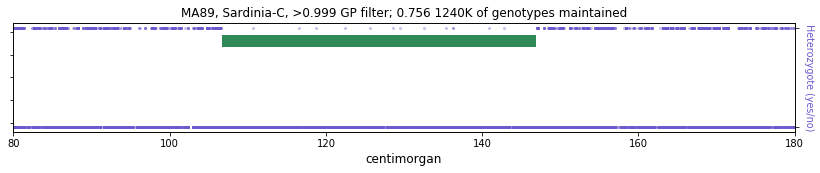

In [157]:
plot_hets(map_het=map_het, het=het, df_roh=df_roh, cm_lim=[80,180], 
          title=f"MA89, Sardinia-C, >{cutoff} GP filter; {c:.3f} 1240K of genotypes maintained", ms=2,
          savepath="./figs/dumpster/MA89.0.999_gp_cutoff.png")

### Analyze the spurious hets

In [96]:
j = get_idx_iid(f, sample="MA89", unique=True)
map_het = f["variants/MAP"][:] # Loat the map
gts =  f["calldata/GT"][:,j,:]
het = gts[:,0]!=gts[:,1]
assert(len(map_het)==len(het))
m = np.max(f["calldata/GP"][:,j,:], axis=1)

idx_m = (map_het > 1.1)  & (map_het<1.4)
idx_het_roh = het & idx_m

In [120]:
print(f"{np.sum(idx_het_roh)} / {np.sum(idx_m)}")

84 / 6840


In [98]:
m[idx_het_roh]

array([0.992, 0.64 , 0.918, 0.832, 0.823, 0.574, 1.   , 0.745, 0.75 ,
       0.665, 0.873, 0.975, 0.962, 0.999, 0.739, 0.564, 0.976, 1.   ,
       0.975, 0.619, 0.666, 0.727, 0.652, 0.567, 1.   , 0.988, 0.513,
       0.785, 0.988, 0.93 , 0.865, 1.   , 0.72 , 0.625, 0.626, 0.627,
       0.584, 0.611, 0.583, 0.533, 0.593, 0.545, 1.   , 0.957, 0.998,
       0.776, 0.997, 1.   , 1.   , 0.842, 0.734, 0.729, 0.964, 0.988,
       0.648, 0.536, 0.543, 0.547, 0.919, 0.867, 0.998, 0.999, 1.   ,
       0.623, 0.525, 0.654, 0.487, 0.999, 0.952, 1.   , 0.582, 0.938,
       1.   , 1.   , 0.703, 0.975, 0.692, 0.999, 0.988, 0.988, 0.725,
       0.808, 0.911, 0.787], dtype=float32)

In [ ]:
list(f["variants"])

In [128]:
f["variants/ALT"][idx_het_roh,0]

array(['C', 'T', 'A', ..., 'G', 'T', 'C'], dtype=object)

In [114]:
gts =  f["calldata/GT"][idx_het_roh,j,:]

### Low Coverage Bell Beaker

In [164]:
cutoff = 0.99
ch = 3
sample = "I4068"

f = h5py.File(f"./data/hdf5/1240k_v43/ch{ch}.h5", "r") # Load for Sanity Check. See below!


j = get_idx_iid(f, sample=sample, unique=True)
print(f"Read Coverage 1240K: {get_coverage(f,j):.4f}")
map_het = f["variants/MAP"][:] # Loat the map
gts =  f["calldata/GT"][:,j,:]
het = gts[:,0]!=gts[:,1]
assert(len(map_het)==len(het))

m = np.max(f["calldata/GP"][:,j,:], axis=1)
idx = (m>cutoff)
c = np.mean(m>cutoff)
print(f"Filtering to {cutoff} GP variants: {c:.3f}x")

map_het = map_het[idx]
het = het[idx]

### Plot inferred ROH (via hapROH)
df_roh = pd.read_csv(f"/n/groups/reich/hringbauer/hapsburg_runs/output/v43_full/{sample}_roh_full.csv", sep=",")
df_roh = df_roh[df_roh["ch"]==ch]
### Extract good variants

f.close()

Read Coverage 1240K: 0.4025
Filtering to 0.99 GP variants: 0.711x


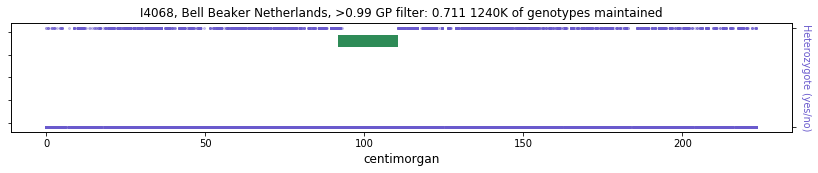

In [167]:
plot_hets(map_het=map_het, het=het, df_roh=df_roh, cm_lim=[], min_cm=4,
          title=f"I4068, Bell Beaker Netherlands, >{cutoff} GP filter: {c:.3f} 1240K of genotypes maintained", ms=2,
          savepath="") # ./figs/dumpster/I4068, Bell Beaker_0.5_gp_cutoff.png

# Plot low coverage Italian

In [149]:
cutoff = 0.9
ch = 3
sample = "R121.SG"

f = h5py.File(f"./data/hdf5/1240k_v43/ch{ch}.h5", "r") # Load for Sanity Check. See below!
j = get_idx_iid(f, sample=sample, unique=True)
map_het = f["variants/MAP"][:] # Loat the map
gts =  f["calldata/GT"][:,j,:]
het = gts[:,0]!=gts[:,1]
assert(len(map_het)==len(het))

m = np.max(f["calldata/GP"][:,j,:], axis=1)
idx = (m>cutoff)
c = np.mean(m>cutoff)
print(f"Filtering to {cutoff} GP variants: {c:.3f}x")

map_het = map_het[idx]
het = het[idx]

### Plot inferred ROH (via hapROH)
df_roh = pd.read_csv(f"/n/groups/reich/hringbauer/hapsburg_runs/output/v43_full/{sample}_roh_full.csv", sep=",")
df_roh = df_roh[df_roh["ch"]==ch]
### Extract good variants

f.close()

Filtering to 0.9 GP variants: 0.971x


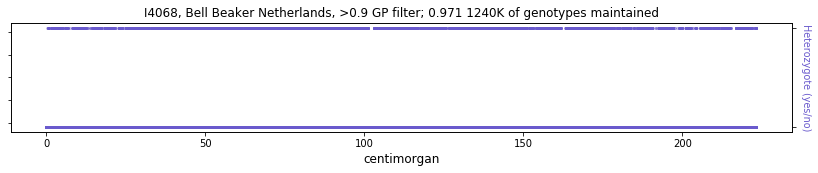

In [150]:
plot_hets(map_het=map_het, het=het, df_roh=df_roh, cm_lim=[], min_cm=4,
          title=f"I4068, Bell Beaker Netherlands, >{cutoff} GP filter; {c:.3f} 1240K of genotypes maintained", ms=2,
          savepath="") # ./figs/dumpster/I4068, Bell Beaker_0.5_gp_cutoff.png

In [151]:
df_roh = pd.read_csv(f"/n/groups/reich/hringbauer/hapsburg_runs/output/v43_full/{sample}_roh_full.csv", sep=",")

In [152]:
df_roh

,Start,End,StartM,EndM,length,lengthM,iid,ch
0,19850,24736,1.205631,1.475718,4886,0.270087,R121.SG,4
1,18394,22027,1.087204,1.257559,3633,0.170355,R121.SG,5
2,22048,22716,1.258735,1.298523,668,0.039788,R121.SG,5
3,28021,29315,1.580223,1.624786,1294,0.044563,R121.SG,5
4,28447,28603,1.771207,1.792543,156,0.021336,R121.SG,7
5,0,408,0.001710,0.044724,408,0.043014,R121.SG,12
6,25818,26061,1.660845,1.685672,243,0.024827,R121.SG,12
7,4951,5248,0.390234,0.419764,297,0.029530,R121.SG,13
8,8845,15056,0.610152,0.915318,6211,0.305166,R121.SG,13
9,3256,4208,0.332448,0.375516,952,0.043068,R121.SG,14
